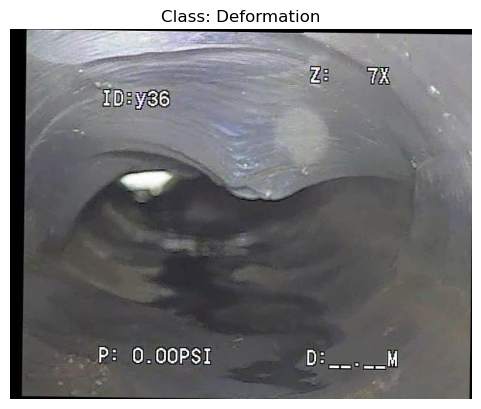

In [11]:
import os
import random
import yaml
from PIL import Image
import matplotlib.pyplot as plt

# Caminhos para os diretórios
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'
config_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\config.yaml'

# Carregar o arquivo de configuração
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Mapeamento das classes
class_names = config['names']

# Obter lista de arquivos de imagens
image_files = os.listdir(images_path)

# Selecionar uma imagem aleatória
random_image = random.choice(image_files)

# Carregar a imagem usando PIL
image_path = os.path.join(images_path, random_image)
image = Image.open(image_path)

# Obter o nome do arquivo da label correspondente
label_file = random_image.replace('.jpg', '.txt')  # Ajuste conforme o formato real
label_path = os.path.join(labels_path, label_file)

# Carregar a label e extrair a classe (primeiro número da linha)
with open(label_path, 'r') as file:
    line = file.readline().strip()
    label = int(line.split()[0])  # Extrair apenas o índice da classe

# Exibir a imagem com a classificação
plt.imshow(image)
plt.title(f'Class: {class_names[label]}')
plt.axis('off')  # Desabilitar os eixos
plt.show()


Explicação do código:
Carregamento de imagens e labels: As imagens são carregadas e redimensionadas para (128, 128) usando PIL. Os labels são extraídos dos arquivos .txt e mapeados para as classes correspondentes.
Pré-processamento: A normalização é realizada para garantir que os valores dos pixels estejam no intervalo [0, 1]. O conjunto de dados é dividido em treinamento, validação e teste, com 70%, 15% e 15%, respectivamente.
Data Augmentation: Para lidar com o desbalanceamento, são aplicadas transformações como rotação, deslocamento e flip nas imagens de treino.
Modelo CNN: A arquitetura da rede consiste em camadas Conv2D para extração de características, MaxPooling2D para redução de dimensionalidade, e camadas densas para classificação final.
Treinamento: O modelo é treinado com o otimizador Adam, usando o categorical_crossentropy como função de perda. O EarlyStopping é utilizado para evitar overfitting.
Avaliação: A acurácia, o F1-score e a matriz de confusão são calculados para avaliar a performance do modelo no conjunto de teste.
Curvas de treinamento: A evolução da acurácia ao longo das épocas é plotada.
Esse código é um ponto de partida para seu modelo de CNN, que pode ser ajustado conforme necessário (por exemplo, adicionando mais camadas ou ajustando os parâmetros de treinamento).

In [2]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

from PIL import Image

# Caminho para as imagens e labels
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Função para carregar e processar as imagens com lazy loading
def load_and_process_images(images_path, labels_path, img_size=(128, 128)):
    image_files = os.listdir(images_path)
    images = []
    labels = []

    for image_file in image_files:
        # Carregar a imagem
        img = Image.open(os.path.join(images_path, image_file))
        img = img.resize(img_size)  # Redimensionar a imagem
        img = np.array(img, dtype=np.float16)  # Usar float16 para reduzir o uso de memória
        img = img / 255.0  # Normalizar para o intervalo [0, 1]
        
        # Carregar o arquivo de labels correspondente
        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0])  # Extrair a classe do defeito

        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

# Carregar as imagens e labels
X, y = load_and_process_images(images_path, labels_path)

# Dividir os dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Converter labels para one-hot encoding
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Criar o modelo CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))  # Mais convoluções
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Mais neurônios
model.add(Dropout(0.5))  # Regularização com Dropout
model.add(Dense(num_classes, activation='softmax'))


# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Criar o gerador de dados para treino e validação
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=4)  # Tamanho de lote menor para reduzir uso de memória
val_generator = val_datagen.flow(X_val, y_val, batch_size=4)

# Treinar o modelo
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Avaliar o modelo
loss, accuracy = model.evaluate(val_generator)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

# Avaliar no conjunto de teste
test_generator = val_datagen.flow(X_test, y_test, batch_size=4)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


C:\Users\lidia\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\lidia\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3871/3871 ━━━━━━━━━━━━━━━━━━━━ 383s 98ms/step - accuracy: 0.2108 - loss: 1.7537 - val_accuracy: 0.3593 - val_loss: 1.5222
Epoch 2/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 366s 94ms/step - accuracy: 0.3641 - loss: 1.5411 - val_accuracy: 0.3945 - val_loss: 1.4618
Epoch 3/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 368s 95ms/step - accuracy: 0.3838 - loss: 1.4795 - val_accuracy: 0.4120 - val_loss: 1.4230
Epoch 4/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 370s 96ms/step - accuracy: 0.4041 - loss: 1.4395 - val_accuracy: 0.4298 - val_loss: 1.3721
Epoch 5/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 372s 96ms/step - accuracy: 0.4304 - loss: 1.3868 - val_accuracy: 0.4509 - val_loss: 1.3388
Epoch 6/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 365s 94ms/step - accuracy: 0.4560 - loss: 1.3372 - val_accuracy: 0.4837 - val_loss: 1.3073
Epoch 7/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 357s 92ms/step - accuracy: 0.4852 - loss: 1.2742 - val_accuracy: 0.4837 - val_loss: 1.2873
Epoch 8/10
3871/3871 ━━━━━━━━━━━━━━━━━━━━ 344s 89ms/step - accuracy: 0.5033 - lo

In [1]:
from PIL import Image
import os

# Caminho das imagens
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'

# Obter uma lista de arquivos de imagem
image_files = os.listdir(images_path)

# Escolher uma imagem aleatória ou a primeira da lista
sample_image_path = os.path.join(images_path, image_files[0])

# Abrir a imagem
with Image.open(sample_image_path) as img:
    width, height = img.size
    print(f"Dimensões da imagem: {width}x{height} (Largura x Altura)")
    print(f"Formato: {img.format}")  # Ex: JPEG, PNG
    print(f"Modo de cor: {img.mode}")  # Ex: RGB, L



Dimensões da imagem: 720x576 (Largura x Altura)
Formato: JPEG
Modo de cor: RGB


In [2]:
dimensions = []
for image_file in image_files:
    image_path = os.path.join(images_path, image_file)
    with Image.open(image_path) as img:
        dimensions.append(img.size)

# Exibir as dimensões únicas
unique_dimensions = set(dimensions)
print(f"Dimensões únicas das imagens: {unique_dimensions}")


Dimensões únicas das imagens: {(704, 576), (511, 383), (616, 347), (625, 469), (462, 347), (400, 400), (580, 464), (520, 416), (640, 368), (608, 486), (567, 454), (509, 382), (589, 442), (609, 487), (584, 467), (789, 631), (450, 338), (640, 480), (582, 466), (720, 540), (462, 260), (875, 700), (539, 303), (320, 240), (720, 576), (480, 360), (704, 528), (518, 414), (816, 653), (640, 360), (481, 385)}


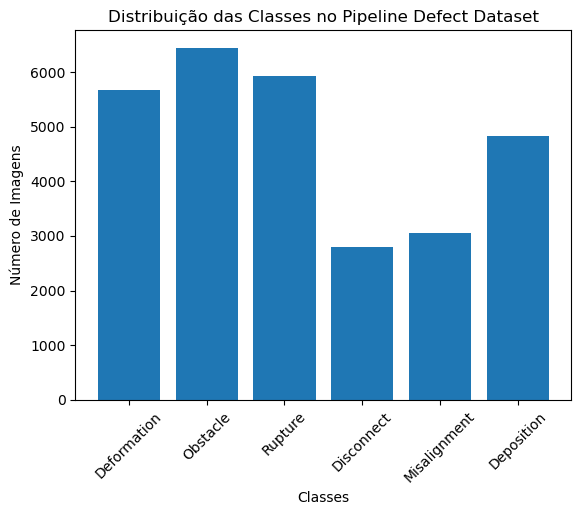

Deformation: 5676 imagens
Obstacle: 6441 imagens
Rupture: 5933 imagens
Disconnect: 2804 imagens
Misalignment: 3056 imagens
Deposition: 4820 imagens


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Caminho para os arquivos de labels
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Inicializar contadores para as classes
class_counts = np.zeros(6, dtype=int)

# Percorrer todos os arquivos de labels
for label_file in os.listdir(labels_path):
    file_path = os.path.join(labels_path, label_file)
    with open(file_path, 'r') as file:
        for line in file:
            class_index = int(line.split()[0])  # Pegar o índice da classe
            class_counts[class_index] += 1

# Nomes das classes
class_names = ['Deformation', 'Obstacle', 'Rupture', 'Disconnect', 'Misalignment', 'Deposition']

# Plotar o gráfico de barras
plt.bar(class_names, class_counts)
plt.xlabel('Classes')
plt.ylabel('Número de Imagens')
plt.title('Distribuição das Classes no Pipeline Defect Dataset')
plt.xticks(rotation=45)
plt.show()

# Exibir contagem por classe
for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count} imagens")


In [1]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Caminho para as imagens e labels
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Função para carregar e processar as imagens
def load_and_process_images(images_path, labels_path, img_size=(128, 128)):
    image_files = os.listdir(images_path)
    images, labels = [], []

    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file))
        img = img.resize(img_size)
        img = np.array(img, dtype=np.float16) / 255.0

        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0])

        label = 1 if label == 2 else 0  # 1 para "Rupture", 0 para outros defeitos
        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Carregar e dividir os dados
X, y = load_and_process_images(images_path, labels_path)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Aumentar a classe "Rupture" com oversampling
indices_rupture = np.where(y_train == 1)[0]
X_train_rupture = X_train[indices_rupture]
y_train_rupture = y_train[indices_rupture]

X_train = np.concatenate([X_train, X_train_rupture])
y_train = np.concatenate([y_train, y_train_rupture])

# Criar o gerador de dados com Data Augmentation para a classe "Rupture"
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
val_generator = val_datagen.flow(X_val, y_val, batch_size=8)

# Focal Loss personalizada
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        return alpha * tf.pow((1 - pt), gamma) * bce
    return loss

# Criar o modelo CNN aprimorado
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.4),  # Reduzido para melhorar generalização
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Avaliar o modelo no conjunto de teste
test_generator = val_datagen.flow(X_test, y_test, batch_size=8)
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


C:\Users\lidia\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lidia\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 289s 124ms/step - accuracy: 0.6807 - loss: 0.0598 - val_accuracy: 0.8137 - val_loss: 0.0516
Epoch 2/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 269s 117ms/step - accuracy: 0.6811 - loss: 0.0585 - val_accuracy: 0.8137 - val_loss: 0.0500
Epoch 3/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 292s 127ms/step - accuracy: 0.6855 - loss: 0.0577 - val_accuracy: 0.8131 - val_loss: 0.0510
Epoch 4/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 286s 125ms/step - accuracy: 0.6886 - loss: 0.0574 - val_accuracy: 0.8137 - val_loss: 0.0503
Epoch 5/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 274s 119ms/step - accuracy: 0.6837 - loss: 0.0571 - val_accuracy: 0.8137 - val_loss: 0.0481
Epoch 6/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 266s 116ms/step - accuracy: 0.6914 - loss: 0.0563 - val_accuracy: 0.8089 - val_loss: 0.0496
Epoch 7/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 268s 117ms/step - accuracy: 0.6877 - loss: 0.0557 - val_accuracy: 0.8137 - val_loss: 0.0478
Epoch 8/30
2296/2296 ━━━━━━━━━━━━━━━━━━━━ 269s 117ms/step - ac

In [3]:
# Relatório de classificação
from sklearn.metrics import classification_report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2701
           1       0.43      0.09      0.14       617

    accuracy                           0.81      3318
   macro avg       0.63      0.53      0.52      3318
weighted avg       0.75      0.81      0.75      3318



In [4]:
import os
import numpy as np
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from PIL import Image

# Inicializar Wandb
wandb.login()
wandb.init(project="pipeline-defect-rupture")

# Caminhos para imagens e labels
images_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\images\images\train'
labels_path = r'C:\Users\lidia\OneDrive\Área de Trabalho\Mestrado\Visão Computacional\pipeline_dataset\labels\labels\train'

# Função para carregar e processar imagens
def load_and_process_images(images_path, labels_path, img_size=(224, 224)):
    image_files = os.listdir(images_path)
    images = []
    labels = []

    for image_file in image_files:
        img = Image.open(os.path.join(images_path, image_file)).resize(img_size)
        img = np.array(img, dtype=np.float32) / 255.0
        
        label_file = image_file.replace('.jpg', '.txt')
        with open(os.path.join(labels_path, label_file), 'r') as f:
            label = int(f.readline().split()[0] == 2)  # '1' para Rupture, '0' para o restante

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Carregar imagens e labels
X, y = load_and_process_images(images_path, labels_path)

# Dividir os dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Data Augmentation
train_datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
val_datagen = ImageDataGenerator()

# Criar o gerador de dados
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)
val_generator = val_datagen.flow(X_val, y_val, batch_size=16)

# Criar modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['Precision', 'Recall'])

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinar o modelo
epochs = 20
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, WandbCallback()]
)

# Avaliar o modelo
test_generator = val_datagen.flow(X_test, y_test, batch_size=16)
test_loss, test_precision, test_recall = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Exibir curvas de aprendizado
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\lidia\_netrc
wandb: Currently logged in as: lidiastadtlober (lidiastadtlober-universidade-federal-de-santa-catarina). Use `wandb login --relogin` to force relogin


MemoryError: Unable to allocate 12.4 GiB for an array with shape (22120, 224, 224, 3) and data type float32